In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from sklearn.model_selection import train_test_split
import random
import math
from numpy.random import seed
import joblib
import torch.nn.functional as F
from sklearn import preprocessing
import copy
import statistics

#Reproducability of Results
seed(1)
torch.cuda.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class DNNRegression(torch.nn.Module):
    
    def __init__(self,number_of_inputs,hidden_layer_size,number_of_outputs):
        super(DNNRegression, self).__init__()
        self.hidden = torch.nn.Linear(number_of_inputs,hidden_layer_size)
        self.hidden2 = torch.nn.Linear(hidden_layer_size,128)
        self.hidden3 = torch.nn.Linear(128,256)
        self.hidden4 = torch.nn.Linear(256,512)
        self.predict = torch.nn.Linear(512,number_of_outputs)
        
    def forward(self,x):
        x = F.relu(self.hidden(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.predict(x))
        return x

In [3]:
#Dataset Import and Transform into Torch Training/Testing Tensors
label_enc_tx = preprocessing.MinMaxScaler(feature_range=(0,1))
label_enc_no_tx = preprocessing.MinMaxScaler(feature_range=(0,1))

def Dataset(with_tx):
    if with_tx:
        data = pd.read_csv('Dataset/data_tx.csv')
        train_data, test_data = train_test_split(data.values,test_size=0.2,shuffle=True)
        return label_enc_tx.fit_transform(train_data),label_enc_tx.transform(test_data)
    else:
        data = pd.read_csv('Dataset/data_no_tx.csv')
        train_data,test_data = train_test_split(data.values,test_size=0.2,shuffle=True)
    return label_enc_no_tx.fit_transform(train_data),label_enc_no_tx.transform(test_data)

In [4]:
data_tx,_ = Dataset(True)
data_no_tx, _ = Dataset(False)

print(data_tx.shape,data_no_tx.shape)

def load_predictor(with_tx):
    if with_tx:
        scaler = joblib.load('Models/label_enc_tx.save')
        model = DNNRegression(data_tx.shape[1] - 3,64,3)
        model.load_state_dict(torch.load('Models/model_tx.pt'))
        return model,scaler
    else:
        scaler = joblib.load('Models/label_enc_no_tx.save')
        model = DNNRegression(data_no_tx.shape[1] - 2,64,2)
        model.load_state_dict(torch.load('Models/model_no_tx.pt'))
        return model,scaler

(549, 13) (7789, 10)


In [5]:
class RL_GA(nn.Module):
    #defines a Genetic Algorithm Approach to Reinforcement learning model
    
    def __init__(self,number_of_inputs,hidden_layer_size,number_of_outputs):
        super(RL_GA,self).__init__()
        self.fc = nn.Sequential(
        nn.Linear(number_of_inputs,hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size,number_of_outputs))
        
    def forward(self,x):
        return self.fc(x)

In [6]:
#Import DNN Regression Model for EC/MS/TP predictions

data_tx,_ = Dataset(True)
data_no_tx, _ = Dataset(False)

print(data_tx.shape,data_no_tx.shape)

def load_predictor(with_tx):
    if with_tx:
        scaler = joblib.load('Models/label_enc_tx.save')
        model = DNNRegression(data_tx.shape[1] - 3,64,3)
        model.load_state_dict(torch.load('Models/model_tx.pt'))
        return model,scaler
    else:
        scaler = joblib.load('Models/label_enc_no_tx.save')
        model = DNNRegression(data_no_tx.shape[1] - 2,64,2)
        model.load_state_dict(torch.load('Models/model_no_tx.pt'))
        return model,scaler

(549, 13) (7789, 10)


In [7]:
def save_model(model,with_tx,target_kpi):
    model_state = {
        'state_dict': model.state_dict()}
    if with_tx: 
        tx = "tx"
    else:
        tx = "no_tx"
    
    model_save_name = F"model_{tx}_GA_{target_kpi}.tar"
    path = F"Models/{model_save_name}"
    torch.save(model_state, path)

In [8]:
def Random_Action(output,epsilon):
    action = torch.zeros([NUMBER_OF_OUTPUTS], dtype=torch.float32)
    random_action = random.random() < 0

    if random_action:
        action[random.randrange(NUMBER_OF_OUTPUTS)] = 1
    else:
        with torch.no_grad():
            action[torch.argmax(output).item()] = 1
            
    return action

In [9]:
#Reward Calculation

def CalculateReward(current_state,epoch,target_kpi,with_tx,terminal):
    if epoch == NUMBER_OF_SIM or terminal:
        terminal = True 
    else: terminal = False
    if with_tx:
        ms = current_state[1]
        ec = current_state[0]
        tp = current_state[12]
    else:
        ms = current_state[1]
        ec = current_state[0]
    if target_kpi == "ms":
        # goal is to reduce the ms
        return 1-ms,terminal
    elif target_kpi == "ec":
        return 1-ec,terminal
    elif target_kpi == "tp":
        return tp,terminal
    else:
        if with_tx:
            return ((1-ec) +tp + (1-ms))/3,terminal
        else:
            return 1-(0.5*ec+0.5*ms),terminal
    return -1,False

In [10]:
# [0, 100010, 101]
scaled_timers_tx = [0.0,0.00100989901009899,0.9999999999999999]
# [0, 1, 101, 100010, 11]
scaled_timers_no_tx = [0.0,9.99900009999e-06,0.00010998900109989,0.00100989901009899,0.9999999999999999]
packet_size_no_tx = [0.0,0.016,0.232,0.488,1.0]
packet_size_tx = [ 0.0,0.21951219512195125,0.47967479674796754,1.0]

def Increase_Timer(prev_timer,with_tx):
    if with_tx:
        index = scaled_timers_tx.index(prev_timer)
        return scaled_timers_tx[min(index+1,2)],index==2
    else:
        index = scaled_timers_no_tx.index(prev_timer)
        return scaled_timers_no_tx[min(index+1,2)],index==2

def Decrease_Timer(prev_timer,with_tx):
     if with_tx:
        index = scaled_timers_tx.index(prev_timer)
        return scaled_timers_tx[max(index-1,0)],index==0
     else:
        index = scaled_timers_no_tx.index(prev_timer)
        return scaled_timers_no_tx[max(index-1,0)],index==0

def Increase_Packet_size(prev_packet,with_tx):
    if with_tx:
        index = packet_size_tx.index(prev_packet)
        return packet_size_tx[min(index+1,3)],index==3
    else:
        index = packet_size_no_tx.index(prev_packet)
        return packet_size_no_tx[min(index+1,3)],index==3

def Decrease_Packet_size(prev_packet,with_tx):
    if with_tx:
        index = packet_size_tx.index(prev_packet)
        return packet_size_tx[max(index-1,0)],index==0
    else:
        index = packet_size_no_tx.index(prev_packet)
        return packet_size_no_tx[max(index-1,0)],index==0

In [11]:
# ACTIONS --- 0 - do nothing, 1 - increase active timer, 2 - decrease active timer

# tx Index(['energyConsumption', 'ms', 'tx_power_median', 'ECL_median',
#        'Location Coverage', 'energyConsumptionTx', 'msTx', 'duration',
#        'interval', 'psize', 'active_timer', 'tau', 'Throughput'],
#       dtype='object')
# no tx Index(['energyConsumption', 'ms', 'current_max', 'ECL_median',
#        'Location Coverage', 'duration', 'interval', 'psize', 'active_timer',
#        'tau'],

do_nothing = torch.tensor([1,0,0,0,0]).float()
increase_timer = torch.tensor([0,1,0,0,0]).float()
decrease_timer = torch.tensor([0,0,1,0,0]).float()
increase_packet_size = torch.tensor([0,0,0,1,0]).float()
decrease_packet_size = torch.tensor([0,0,0,0,1]).float()

def Take_Action(current,output,predictor,scaler,with_tx):
    if with_tx:
        if torch.equal(output,do_nothing):
            return current,False
        elif torch.equal(output,increase_packet_size):#
            new_packet,terminal = Increase_Packet_size(current[9],with_tx)
            current[9] = new_packet
        elif torch.equal(output,decrease_packet_size):
            new_packet,terminal = Decrease_Packet_size(current[9],with_tx)
            current[9] = new_packet
        elif torch.equal(output,increase_timer):
            new_timer,terminal = Increase_Timer(current[10],with_tx)
            current[10] = new_timer
        else:
            new_timer,terminal = Decrease_Timer(current[10],with_tx)
            current[10] = new_timer
        
        next_s = current
        #drop ec,ms,tp
        pre_predicted_features = np.delete(current,[0,1,12])
        #input features into predictor
        with torch.no_grad():
            predicted_features = predictor(torch.Tensor(pre_predicted_features))
        #append predicted into new list
        next_s[0] = pre_predicted_features[0]
        next_s[1] = pre_predicted_features[1]
        next_s[12] = pre_predicted_features[2]
        #return list
        return next_s,terminal
           
    else:
        if torch.equal(output,do_nothing):
            return current,False
        elif torch.equal(output,increase_packet_size):
            new_packet,terminal = Increase_Packet_size(current[7],with_tx)
            current[7] = new_packet
        elif torch.equal(output,decrease_packet_size):
            new_packet,terminal = Decrease_Packet_size(current[7],with_tx)
            current[7] = new_packet
        elif torch.equal(output,increase_timer):
            new_timer,terminal = Increase_Timer(current[8],with_tx)
            current[8] = new_timer
        else:
            new_timer,terminal = Decrease_Timer(current[8],with_tx)
            current[8] = new_timer
       
        next_s = current
        #drop ec,ms,tp
        pre_predicted_features = np.delete(next_s,[0,1])
        #Normalise pre predicted features into the same normalisation scale
#         pre_predicted_features = scaler.transform(pre_predicted_features)
        #input features into predictor
        with torch.no_grad():
            predicted_features = predictor(torch.Tensor(pre_predicted_features))
        #append predicted into new list
        next_s[0] = pre_predicted_features[0]
        next_s[1] = pre_predicted_features[1]
        #return list
        return next_s,terminal


In [12]:
#HYPER PARAMETERS

MUTATION_RATE = 0.1
N_POP = 8
N_GEN = 10000
N_KEEP = int(0.5 * N_POP)
NUMBER_OF_OUTPUTS = 5
HIDDEN_LAYER_SIZE = 128
ELITISM = True
NUMBER_OF_SIM = 7
INITIAL_EPSILON = 1
FINAL_EPSILON = 0.01
EPSILON_DECAY = 25000
GAMMA = 0.9
MINIBATCH_SIZE = 7

train_data_tx,_ = Dataset(True)
train_data_no_tx,_ = Dataset(False)

NUMBER_OF_INPUTS_TX = train_data_tx.shape[1]
NUMBER_OF_INPUTS_NO_TX = train_data_no_tx.shape[1]

In [13]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
#         m.bias.data.fill_(0.01)

def Generate_Init_Pop(number_of_population,with_tx):
    
    agents = []
    
    for counter in range(number_of_population):
        
        if with_tx:
            agent = RL_GA(NUMBER_OF_INPUTS_TX,HIDDEN_LAYER_SIZE,NUMBER_OF_OUTPUTS).to(device)
        else:
            agent = RL_GA(NUMBER_OF_INPUTS_NO_TX,HIDDEN_LAYER_SIZE,NUMBER_OF_OUTPUTS).to(device)

        agents.append(agent.apply(init_weights))
    
    return agents

In [14]:
def minibatch_reward(model,replay_memory,NUMBER_OF_INPUTS):
    minibatch = random.sample(replay_memory, min(len(replay_memory), MINIBATCH_SIZE))

    current_batch = torch.zeros(len(minibatch),NUMBER_OF_INPUTS).to(device)
    action_batch = torch.zeros(len(minibatch),NUMBER_OF_OUTPUTS).to(device)
    reward_batch = torch.zeros(len(minibatch)).to(device)
    next_state_batch = torch.zeros(len(minibatch),NUMBER_OF_INPUTS).to(device)
    terminal_state_batch = []
    for idx,data_point in enumerate(minibatch):
        current_batch[idx] = data_point[0]
        action_batch[idx] = data_point[1]
        reward_batch[idx] = data_point[2]
        next_state_batch[idx] = data_point[3]
        terminal_state_batch.append(data_point[4])

    next_state_batch_output = torch.zeros(MINIBATCH_SIZE,NUMBER_OF_INPUTS).to(device)
    for idx in range(next_state_batch.shape[0]):
        next_state_batch_output[idx] = model(next_state_batch[idx]).to(device)[0]

    y_batch = tuple(reward_batch[i] if terminal_state_batch[i]
                        else reward_batch[i] + GAMMA * torch.max(next_state_batch_output[i])
                              for i in range(len(minibatch)))

    return y_batch,current_batch,action_batch,reward_batch,next_state_batch

In [15]:
def Run_Agents(agents,dataset,with_tx,target_kpi):
    
    predictor,scaler = load_predictor(with_tx)
    epsilon = INITIAL_EPSILON
    learn_step_counter = 0
    agent_reward = []
    criterion = nn.MSELoss()
    replay_memory = []
    
    for counter,agent in enumerate(agents):
        rewards = []
        for index,attribute in enumerate(dataset): 
            avg_reward = []
            learn_step_counter += 1
            action = agent(torch.Tensor(attribute).to(device))
            action = Random_Action(action,epsilon)
            next_state,terminal = Take_Action(attribute,action,predictor,scaler,with_tx)
            reward,terminal = CalculateReward(next_state,0,target_kpi,with_tx,terminal)
            for simulated_env in range(NUMBER_OF_SIM):
                next_action = agent(torch.Tensor(next_state).to(device))
                next_action = Random_Action(next_action,epsilon)
                next_state,terminal = Take_Action(next_state,next_action,predictor,scaler,with_tx)
                reward,terminal = CalculateReward(next_state,simulated_env,target_kpi,with_tx,terminal)
                epsilon = FINAL_EPSILON + (INITIAL_EPSILON - FINAL_EPSILON) * math.exp(-1. * learn_step_counter / EPSILON_DECAY)
                
                replay_memory.append((torch.Tensor(attribute).to(device), torch.Tensor(next_action).to(device), reward, torch.Tensor(next_state).to(device), terminal))

                y_batch,current_batch,action_batch,reward_batch,next_state_batch = minibatch_reward(agent,replay_memory,dataset.shape[1])
                
                y_batch = torch.Tensor(y_batch).detach().to(device)
#                 extract Q-value
                q_value = torch.sum(agent(current_batch) * action_batch, dim=1)
                
                loss = criterion(q_value,y_batch)
                avg_reward.append(loss.item())
                
                if terminal:
                    break
            rewards.append(min(avg_reward))
#         print("Agent: [{}/{}], Average Reward: {}".format(counter,len(agents),rewards[counter]))
        agent_reward.append((agent,min(rewards)))
    return agent_reward
    

In [16]:
def Mate_Agents(agents,with_tx):
    # Using Top to Bottom Mating
    
    children = []

    for counter in range(0, len(agents), 2):
        parent_1 = agents[counter]
        parent_2 = agents[counter+1]
        if with_tx:
            child_1 = RL_GA(NUMBER_OF_INPUTS_TX,HIDDEN_LAYER_SIZE,NUMBER_OF_OUTPUTS).to(device)
            child_2 = RL_GA(NUMBER_OF_INPUTS_TX,HIDDEN_LAYER_SIZE,NUMBER_OF_OUTPUTS).to(device)            
        else:
            child_1 = RL_GA(NUMBER_OF_INPUTS_NO_TX,HIDDEN_LAYER_SIZE,NUMBER_OF_OUTPUTS).to(device)
            child_2 = RL_GA(NUMBER_OF_INPUTS_NO_TX,HIDDEN_LAYER_SIZE,NUMBER_OF_OUTPUTS).to(device)

        for index,(name,param) in enumerate(parent_1.named_parameters()):
            if "weight" in name:
                counter = int(name.split(".")[1])
                parent_2_weight = parent_2.fc[counter].weight
                child_1.fc[counter].weight = nn.Parameter(torch.cat((parent_2_weight[:round(parent_2_weight.shape[0]/2)],param[round(param.shape[0]/2):])))
                child_2.fc[counter].weight = nn.Parameter(torch.cat((param[:round(param.shape[0]/2)],parent_2_weight[round(parent_2_weight.shape[0]/2):])))
#             if "bias" in name:
#                 counter = int(name.split(".")[1])
#                 parent_2_bias = parent_2.fc[counter].bias
#                 child_1.fc[counter].bias = nn.Parameter(torch.cat((parent_2_bias[:round(parent_2_bias.shape[0]/2)],param[round(param.shape[0]/2):])))
#                 child_2.fc[counter].bias = nn.Parameter(torch.cat((param[:round(param.shape[0]/2)],parent_2_bias[round(parent_2_bias.shape[0]/2):])))
        children.append(child_1)
        children.append(child_2)
    return agents + children

In [17]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def Mutate_Agents(agents):
    #Elitism implemented 
    
    number_of_mutations_0 = round(MUTATION_RATE * N_POP * agents[0].fc[0].weight.shape[1])
    
    for i in range(number_of_mutations_0):
        agent = agents[random.randint(2,len(agents)-1)]
        row = random.randint(1,agent.fc[0].weight.shape[0]-1)
        col = random.randint(1,agent.fc[0].weight.shape[1]-1)
        agent.fc[0].weight[row,col] = agent.fc[0].weight[row,col]+gaussian(np.mean(agent.fc[0].weight.cpu().detach().numpy()), np.std(agent.fc[0].weight.cpu().detach().numpy()), 1)
        
    number_of_mutations_1 = round(MUTATION_RATE * N_POP * agents[0].fc[2].weight.shape[1])
    
    for i in range(number_of_mutations_0):
        agent = agents[random.randint(1,len(agents)-1)]
        row = random.randint(1,agent.fc[2].weight.shape[0]-1)
        col = random.randint(1,agent.fc[2].weight.shape[1]-1)
        agent.fc[2].weight[row,col] = agent.fc[2].weight[row,col]+gaussian(np.mean(agent.fc[2].weight.cpu().detach().numpy()), np.std(agent.fc[2].weight.cpu().detach().numpy()), 1)
    
    return agents

In [18]:
def GA_Iteration(with_tx,dataset,target_kpi):
    
    best_agent = None
    best_score = 99999
    loss_history = []
    best_gen = 0
    
    torch.set_grad_enabled(False) #wont be using gradient descent but using GA 
    
    #Get Initial Population (Randomly Created Models)
    agents = Generate_Init_Pop(N_POP,with_tx)
                
    for generation in range(N_GEN):
        
        #Run the agents and compute the rewards obtained from each agent (Cost Function)
        agent_reward = Run_Agents(agents,dataset,with_tx,target_kpi)
        
        #Sort agents based on their rewards, highest reward being the best agent
        agents = sorted(agent_reward,key=lambda x:x[1])
        rewards = list(zip(*agents))[1]
        agents = list(zip(*agents))[0]
        
        print("Generation: [{}/{}], Top 3 agent rewards: {}, Mean of Top Loss: {}, Best Score: {}, at: {}".format(generation,N_GEN,rewards[:3],round(np.mean(rewards[:3]),4),round(best_score,4),best_gen))
        
        loss_history.append((generation,rewards[0]))
        
        if rewards[0] < best_score:
            best_agent = agents[0]
            best_score = rewards[0]
            best_gen = generation
            save_model(best_agent,with_tx,target_kpi)
        
        #Kill population that is below N_Keep (Survival of the fittest)
        agents = list(agents[:N_KEEP])
        
        #Cross-over agents to obtain new children agents
        children_agents = Mate_Agents(agents,with_tx)
        
        #Mutate Agents to traverse solution space
        mutated_agents = Mutate_Agents(children_agents)
        
        agents = mutated_agents
        
        #Termination Condition, if best agent hasnt changed for 50 generations
        if generation - best_gen >= 50:
            break
        
        
    return loss_history

Generation: [0/10000], Top 3 agent rewards: (0.00955880805850029, 0.13393600285053253, 0.16043789684772491), Mean of Top Loss: 0.1013, Best Score: 99999, at: 0
Generation: [1/10000], Top 3 agent rewards: (0.02236800268292427, 0.06808505207300186, 0.08423421531915665), Mean of Top Loss: 0.0582, Best Score: 0.0096, at: 0
Generation: [2/10000], Top 3 agent rewards: (0.0041152099147439, 0.017293497920036316, 0.1798984557390213), Mean of Top Loss: 0.0671, Best Score: 0.0096, at: 0
Generation: [3/10000], Top 3 agent rewards: (9.447178308619186e-05, 0.010647214949131012, 0.03131796419620514), Mean of Top Loss: 0.014, Best Score: 0.0041, at: 2
Generation: [4/10000], Top 3 agent rewards: (0.0013452802086248994, 0.009971157647669315, 0.011739520356059074), Mean of Top Loss: 0.0077, Best Score: 0.0001, at: 3
Generation: [5/10000], Top 3 agent rewards: (0.0004413676797412336, 0.002181324874982238, 0.0035412886645644903), Mean of Top Loss: 0.0021, Best Score: 0.0001, at: 3
Generation: [6/10000], To

Generation: [51/10000], Top 3 agent rewards: (0.5773151516914368, 0.641319215297699, 0.8611899018287659), Mean of Top Loss: 0.6933, Best Score: 0.0, at: 16
Generation: [52/10000], Top 3 agent rewards: (0.3194562494754791, 0.3664868175983429, 0.5138153433799744), Mean of Top Loss: 0.3999, Best Score: 0.0, at: 16
Generation: [53/10000], Top 3 agent rewards: (0.07161099463701248, 0.08189620077610016, 0.15107761323451996), Mean of Top Loss: 0.1015, Best Score: 0.0, at: 16
Generation: [54/10000], Top 3 agent rewards: (0.1975373476743698, 0.8276351094245911, 0.9249558448791504), Mean of Top Loss: 0.65, Best Score: 0.0, at: 16
Generation: [55/10000], Top 3 agent rewards: (0.16594494879245758, 0.26647067070007324, 0.3981192409992218), Mean of Top Loss: 0.2768, Best Score: 0.0, at: 16
Generation: [56/10000], Top 3 agent rewards: (0.7477744221687317, 2.0062832832336426, 3.5762059688568115), Mean of Top Loss: 2.1101, Best Score: 0.0, at: 16
Generation: [57/10000], Top 3 agent rewards: (0.24011847

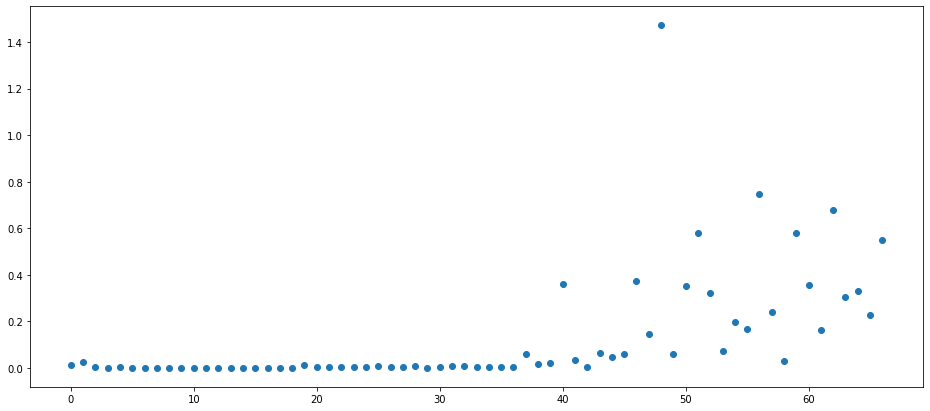

In [19]:
loss_history = GA_Iteration(True,train_data_tx,"all")
loss = list(zip(*loss_history))[1]
plt.figure(1,figsize=(16,7))
plt.scatter(range(len(loss)),loss)
plt.show()

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("tx","GA","all"), index=False)

#DONE

Generation: [0/10000], Top 3 agent rewards: (0.0005685550277121365, 0.0014823154779151082, 0.0033670682460069656), Mean of Top Loss: 0.0018, Best Score: 99999, at: 0
Generation: [1/10000], Top 3 agent rewards: (0.000858251063618809, 0.0027297288179397583, 0.043075162917375565), Mean of Top Loss: 0.0156, Best Score: 0.0006, at: 0
Generation: [2/10000], Top 3 agent rewards: (0.01971781626343727, 0.03891737014055252, 0.06673352420330048), Mean of Top Loss: 0.0418, Best Score: 0.0006, at: 0
Generation: [3/10000], Top 3 agent rewards: (1.3502861975212e-06, 0.00048196688294410706, 0.0006347471498884261), Mean of Top Loss: 0.0004, Best Score: 0.0006, at: 0
Generation: [4/10000], Top 3 agent rewards: (0.0012367324670776725, 0.00186972098890692, 0.009794795885682106), Mean of Top Loss: 0.0043, Best Score: 0.0, at: 3
Generation: [5/10000], Top 3 agent rewards: (0.0010687434114515781, 0.002557795960456133, 0.00959065742790699), Mean of Top Loss: 0.0044, Best Score: 0.0, at: 3
Generation: [6/10000

Generation: [51/10000], Top 3 agent rewards: (0.05316464230418205, 0.0597582645714283, 0.0913124829530716), Mean of Top Loss: 0.0681, Best Score: 0.0, at: 3
Generation: [52/10000], Top 3 agent rewards: (0.047770414501428604, 0.07087042182683945, 0.09555792808532715), Mean of Top Loss: 0.0714, Best Score: 0.0, at: 3
Generation: [53/10000], Top 3 agent rewards: (0.05242278054356575, 0.06976612657308578, 0.07703100144863129), Mean of Top Loss: 0.0664, Best Score: 0.0, at: 3


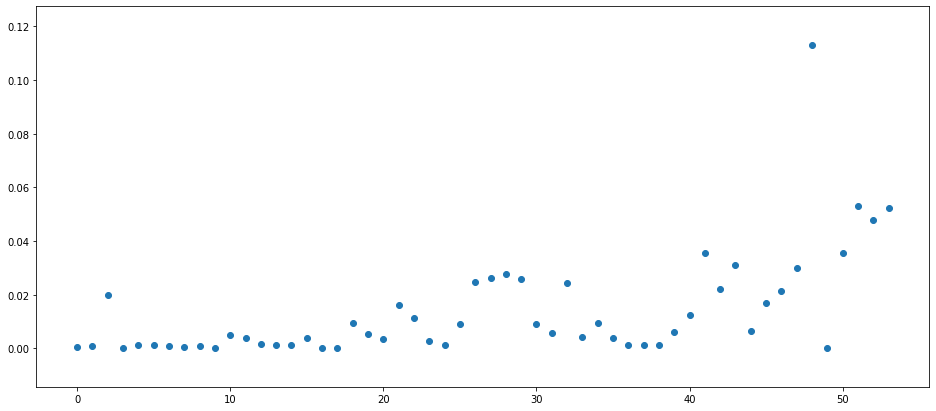

In [19]:
loss_history = GA_Iteration(True,train_data_tx,"tp")
loss = list(zip(*loss_history))[1]
plt.figure(1,figsize=(16,7))
plt.scatter(range(len(loss)),loss)
plt.show()

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("tx","GA","tp"), index=False)

#DONE


Generation: [0/10000], Top 3 agent rewards: (0.0004212133935652673, 0.0009268896537832916, 0.03469941020011902), Mean of Top Loss: 0.012, Best Score: 99999, at: 0
Generation: [1/10000], Top 3 agent rewards: (0.012260169722139835, 0.020197059959173203, 0.022891070693731308), Mean of Top Loss: 0.0184, Best Score: 0.0004, at: 0
Generation: [2/10000], Top 3 agent rewards: (0.0013713202206417918, 0.012684623710811138, 0.019196510314941406), Mean of Top Loss: 0.0111, Best Score: 0.0004, at: 0
Generation: [3/10000], Top 3 agent rewards: (0.0017712869448587298, 0.0027552300598472357, 0.002968516666442156), Mean of Top Loss: 0.0025, Best Score: 0.0004, at: 0
Generation: [4/10000], Top 3 agent rewards: (4.091403025086038e-05, 0.00031262196716852486, 0.000598990241996944), Mean of Top Loss: 0.0003, Best Score: 0.0004, at: 0
Generation: [5/10000], Top 3 agent rewards: (0.00032538044615648687, 0.0018606233643367887, 0.002461639465764165), Mean of Top Loss: 0.0015, Best Score: 0.0, at: 4
Generation:

Generation: [51/10000], Top 3 agent rewards: (0.0016297107795253396, 0.05389817804098129, 0.08333785086870193), Mean of Top Loss: 0.0463, Best Score: 0.0, at: 4
Generation: [52/10000], Top 3 agent rewards: (0.03647121414542198, 0.042937956750392914, 0.13056756556034088), Mean of Top Loss: 0.07, Best Score: 0.0, at: 4
Generation: [53/10000], Top 3 agent rewards: (0.08889137208461761, 0.1140892282128334, 0.1237921193242073), Mean of Top Loss: 0.1089, Best Score: 0.0, at: 4
Generation: [54/10000], Top 3 agent rewards: (0.01549400296062231, 0.03312131389975548, 0.061743296682834625), Mean of Top Loss: 0.0368, Best Score: 0.0, at: 4


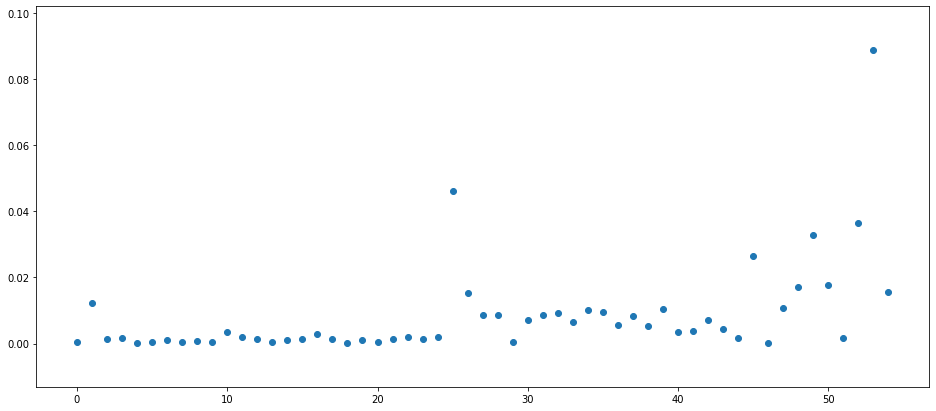

In [19]:
loss_history = GA_Iteration(True,train_data_tx,"ec")
loss = list(zip(*loss_history))[1]
plt.figure(1,figsize=(16,7))
plt.scatter(range(len(loss)),loss)
plt.show()

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("tx","GA","ec"), index=False)

#Done

Generation: [0/10000], Top 3 agent rewards: (0.11482720822095871, 0.11487133055925369, 0.14755359292030334), Mean of Top Loss: 0.1258, Best Score: 99999, at: 0
Generation: [1/10000], Top 3 agent rewards: (0.006580919958651066, 0.0438915491104126, 0.07561598718166351), Mean of Top Loss: 0.042, Best Score: 0.1148, at: 0
Generation: [2/10000], Top 3 agent rewards: (0.0030403246637433767, 0.022822711616754532, 0.04050659015774727), Mean of Top Loss: 0.0221, Best Score: 0.0066, at: 1
Generation: [3/10000], Top 3 agent rewards: (5.491766614795779e-07, 0.02044663019478321, 0.02221756801009178), Mean of Top Loss: 0.0142, Best Score: 0.003, at: 2
Generation: [4/10000], Top 3 agent rewards: (0.000506565032992512, 0.004272902850061655, 0.005664707161486149), Mean of Top Loss: 0.0035, Best Score: 0.0, at: 3
Generation: [5/10000], Top 3 agent rewards: (0.0023393670562654734, 0.0024555851705372334, 0.003294486552476883), Mean of Top Loss: 0.0027, Best Score: 0.0, at: 3
Generation: [6/10000], Top 3 a

Generation: [51/10000], Top 3 agent rewards: (7.821809413144365e-05, 0.006132814567536116, 0.0071581569500267506), Mean of Top Loss: 0.0045, Best Score: 0.0, at: 3
Generation: [52/10000], Top 3 agent rewards: (0.000758285925257951, 0.001040731673128903, 0.0036889761686325073), Mean of Top Loss: 0.0018, Best Score: 0.0, at: 3
Generation: [53/10000], Top 3 agent rewards: (0.0008497791714034975, 0.00372009607963264, 0.013745574280619621), Mean of Top Loss: 0.0061, Best Score: 0.0, at: 3


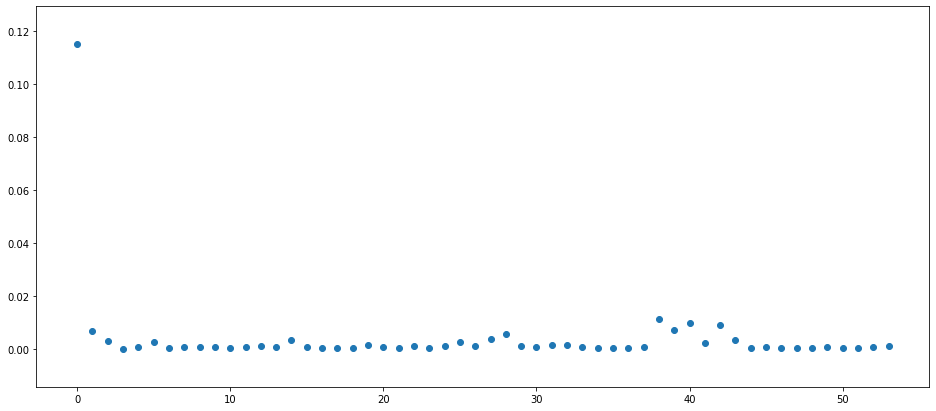

In [20]:
loss_history = GA_Iteration(True,train_data_tx,"ms")
loss = list(zip(*loss_history))[1]
plt.figure(1,figsize=(16,7))
plt.scatter(range(len(loss)),loss)
plt.show()

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("tx","GA","ms"), index=False)

#DONE

Generation: [0/10000], Top 3 agent rewards: (0.08346132189035416, 0.09857472032308578, 0.20926222205162048), Mean of Top Loss: 0.1304, Best Score: 99999, at: 0
Generation: [1/10000], Top 3 agent rewards: (0.05038314312696457, 0.1040852889418602, 0.11178449541330338), Mean of Top Loss: 0.0888, Best Score: 0.0835, at: 0
Generation: [2/10000], Top 3 agent rewards: (0.0034211284946650267, 0.01991449110209942, 0.03738447651267052), Mean of Top Loss: 0.0202, Best Score: 0.0504, at: 1
Generation: [3/10000], Top 3 agent rewards: (0.003617102513089776, 0.02030620351433754, 0.03708525747060776), Mean of Top Loss: 0.0203, Best Score: 0.0034, at: 2
Generation: [4/10000], Top 3 agent rewards: (0.0011096675880253315, 0.018445078283548355, 0.01985679194331169), Mean of Top Loss: 0.0131, Best Score: 0.0034, at: 2
Generation: [5/10000], Top 3 agent rewards: (0.001013319124467671, 0.005611230153590441, 0.010945002548396587), Mean of Top Loss: 0.0059, Best Score: 0.0011, at: 4
Generation: [6/10000], Top 

Generation: [50/10000], Top 3 agent rewards: (0.00018956999701913446, 0.016802627593278885, 0.016901979222893715), Mean of Top Loss: 0.0113, Best Score: 0.0, at: 33
Generation: [51/10000], Top 3 agent rewards: (0.00010011970152845606, 0.0026951574254781008, 0.00499120494350791), Mean of Top Loss: 0.0026, Best Score: 0.0, at: 33
Generation: [52/10000], Top 3 agent rewards: (0.0012812729692086577, 0.0012988504022359848, 0.005330316256731749), Mean of Top Loss: 0.0026, Best Score: 0.0, at: 33
Generation: [53/10000], Top 3 agent rewards: (4.7294917749240994e-05, 0.000737236172426492, 0.0032560660038143396), Mean of Top Loss: 0.0013, Best Score: 0.0, at: 33
Generation: [54/10000], Top 3 agent rewards: (6.603282963624224e-05, 0.0016710901400074363, 0.0047241211868822575), Mean of Top Loss: 0.0022, Best Score: 0.0, at: 53
Generation: [55/10000], Top 3 agent rewards: (0.0003836569667328149, 0.0034114609006792307, 0.004009249620139599), Mean of Top Loss: 0.0026, Best Score: 0.0, at: 53
Generati

Generation: [100/10000], Top 3 agent rewards: (0.0001225066080223769, 0.0015230218414217234, 0.005132337100803852), Mean of Top Loss: 0.0023, Best Score: 0.0, at: 61
Generation: [101/10000], Top 3 agent rewards: (0.00011854590411530808, 0.0024006948806345463, 0.008167966268956661), Mean of Top Loss: 0.0036, Best Score: 0.0, at: 61
Generation: [102/10000], Top 3 agent rewards: (0.00015057944983709604, 0.0038948170840740204, 0.004365408327430487), Mean of Top Loss: 0.0028, Best Score: 0.0, at: 61
Generation: [103/10000], Top 3 agent rewards: (0.00018684666429180652, 0.004570250399410725, 0.009942306205630302), Mean of Top Loss: 0.0049, Best Score: 0.0, at: 61
Generation: [104/10000], Top 3 agent rewards: (0.0001760783197823912, 0.0021490640938282013, 0.005090420134365559), Mean of Top Loss: 0.0025, Best Score: 0.0, at: 61
Generation: [105/10000], Top 3 agent rewards: (0.0002587032213341445, 0.0013665978331118822, 0.004667394328862429), Mean of Top Loss: 0.0021, Best Score: 0.0, at: 61
Ge

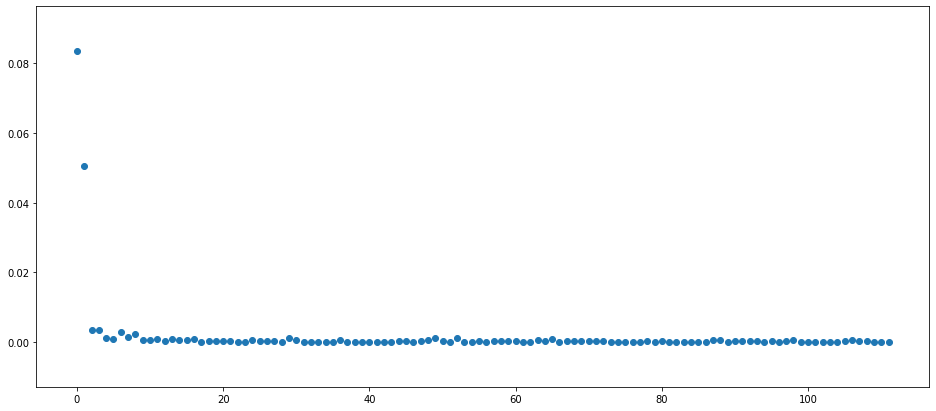

In [21]:
loss_history = GA_Iteration(False,train_data_no_tx,"all")
loss = list(zip(*loss_history))[1]
plt.figure(1,figsize=(16,7))
plt.scatter(range(len(loss)),loss)
plt.show()

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("no_tx","GA","all"), index=False)

#DONE

Generation: [0/10000], Top 3 agent rewards: (0.0863703116774559, 0.13416780531406403, 0.16639010608196259), Mean of Top Loss: 0.129, Best Score: 99999, at: 0
Generation: [1/10000], Top 3 agent rewards: (0.0002071739436360076, 0.007818294689059258, 0.041231535375118256), Mean of Top Loss: 0.0164, Best Score: 0.0864, at: 0
Generation: [2/10000], Top 3 agent rewards: (0.0002071739436360076, 0.011457917280495167, 0.030920153483748436), Mean of Top Loss: 0.0142, Best Score: 0.0002, at: 1
Generation: [3/10000], Top 3 agent rewards: (0.03106374479830265, 0.032016489654779434, 0.04269375279545784), Mean of Top Loss: 0.0353, Best Score: 0.0002, at: 1
Generation: [4/10000], Top 3 agent rewards: (0.009622009471058846, 0.012691500596702099, 0.022526102140545845), Mean of Top Loss: 0.0149, Best Score: 0.0002, at: 1
Generation: [5/10000], Top 3 agent rewards: (0.0011793436715379357, 0.0071176327764987946, 0.01016108226031065), Mean of Top Loss: 0.0062, Best Score: 0.0002, at: 1
Generation: [6/10000]

Generation: [50/10000], Top 3 agent rewards: (0.0009531531832180917, 0.002714895410463214, 0.0031600543297827244), Mean of Top Loss: 0.0023, Best Score: 0.0, at: 31
Generation: [51/10000], Top 3 agent rewards: (0.0017476174980401993, 0.002537122229114175, 0.003393483115360141), Mean of Top Loss: 0.0026, Best Score: 0.0, at: 31
Generation: [52/10000], Top 3 agent rewards: (0.0010583578841760755, 0.005075536202639341, 0.007612832821905613), Mean of Top Loss: 0.0046, Best Score: 0.0, at: 31
Generation: [53/10000], Top 3 agent rewards: (0.0037467346992343664, 0.004574372433125973, 0.009937791153788567), Mean of Top Loss: 0.0061, Best Score: 0.0, at: 31
Generation: [54/10000], Top 3 agent rewards: (0.005964316427707672, 0.0063753752037882805, 0.006961763836443424), Mean of Top Loss: 0.0064, Best Score: 0.0, at: 31
Generation: [55/10000], Top 3 agent rewards: (0.003680886933580041, 0.004201095551252365, 0.005127664655447006), Mean of Top Loss: 0.0043, Best Score: 0.0, at: 31
Generation: [56/

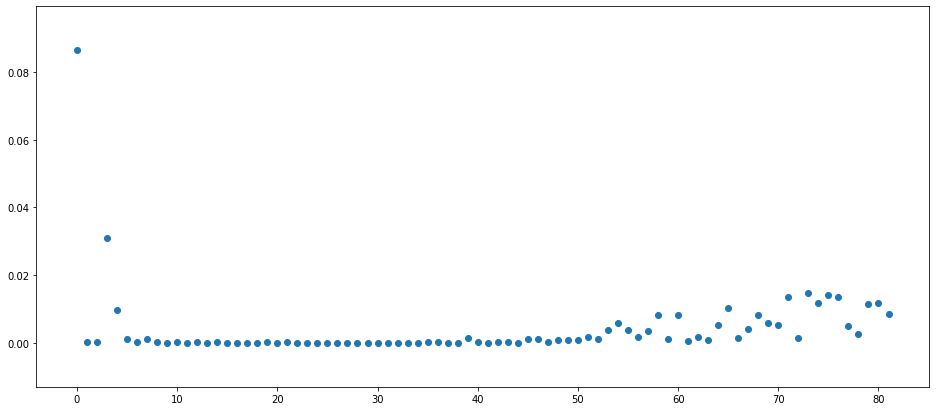

In [22]:
loss_history = GA_Iteration(False,train_data_no_tx,"ec")
loss = list(zip(*loss_history))[1]
plt.figure(1,figsize=(16,7))
plt.scatter(range(len(loss)),loss)
plt.show()

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("no_tx","GA","ec"), index=False)

#DONE

Generation: [0/10000], Top 3 agent rewards: (0.060644034296274185, 0.07548222690820694, 0.09878523647785187), Mean of Top Loss: 0.0783, Best Score: 99999, at: 0
Generation: [1/10000], Top 3 agent rewards: (0.0015200189081951976, 0.006586889270693064, 0.00833222921937704), Mean of Top Loss: 0.0055, Best Score: 0.0606, at: 0
Generation: [2/10000], Top 3 agent rewards: (0.004632276017218828, 0.022764593362808228, 0.023647582158446312), Mean of Top Loss: 0.017, Best Score: 0.0015, at: 1
Generation: [3/10000], Top 3 agent rewards: (0.0031311288475990295, 0.006074161734431982, 0.011291725561022758), Mean of Top Loss: 0.0068, Best Score: 0.0015, at: 1
Generation: [4/10000], Top 3 agent rewards: (0.0015146632213145494, 0.0065859099850058556, 0.0072944993153214455), Mean of Top Loss: 0.0051, Best Score: 0.0015, at: 1
Generation: [5/10000], Top 3 agent rewards: (0.0015984714264050126, 0.005637045484036207, 0.006082799751311541), Mean of Top Loss: 0.0044, Best Score: 0.0015, at: 4
Generation: [6/

Generation: [50/10000], Top 3 agent rewards: (0.0013341634767130017, 0.0019989514257758856, 0.013264670968055725), Mean of Top Loss: 0.0055, Best Score: 0.0, at: 17
Generation: [51/10000], Top 3 agent rewards: (0.0013350257650017738, 0.0028127965051680803, 0.00803267490118742), Mean of Top Loss: 0.0041, Best Score: 0.0, at: 17
Generation: [52/10000], Top 3 agent rewards: (0.0013350257650017738, 0.009218530729413033, 0.027562513947486877), Mean of Top Loss: 0.0127, Best Score: 0.0, at: 17
Generation: [53/10000], Top 3 agent rewards: (0.0013341634767130017, 0.025502508506178856, 0.02692510187625885), Mean of Top Loss: 0.0179, Best Score: 0.0, at: 17
Generation: [54/10000], Top 3 agent rewards: (0.0013341634767130017, 0.01474512554705143, 0.015317254699766636), Mean of Top Loss: 0.0105, Best Score: 0.0, at: 17
Generation: [55/10000], Top 3 agent rewards: (0.0013341634767130017, 0.002105176215991378, 0.018555330112576485), Mean of Top Loss: 0.0073, Best Score: 0.0, at: 17
Generation: [56/1

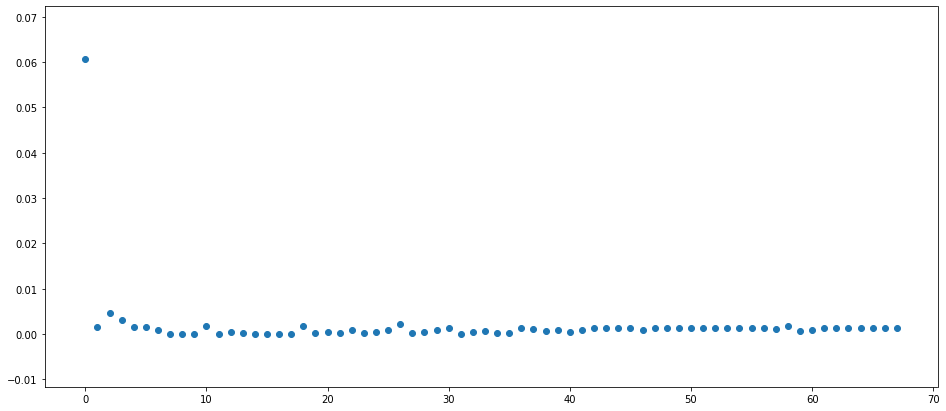

In [23]:
loss_history = GA_Iteration(False,train_data_no_tx,"ms")
loss = list(zip(*loss_history))[1]
plt.figure(1,figsize=(16,7))
plt.scatter(range(len(loss)),loss)
plt.show()

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("no_tx","GA","ms"), index=False)

#DONE